In [1]:
image_input_size = (80,60,3)

### Veri Seti

In [2]:
import os 
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
os.getcwd()

'C:\\Users\\Asus\\Desktop\\RAPOR ÖDEV'

In [4]:
os.listdir('./dataset/')

['archive.zip',
 'HAM10000_images',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv']

In [5]:
metadata = pd.read_csv("./dataset/HAM10000_metadata.csv")

In [6]:
categories = metadata["dx"]
img_names = metadata["image_id"]
categories = np.array(categories)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img_names, categories, test_size=0.33, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(X_train.shape[0] + X_test.shape[0], len(img_names))
print(y_train.shape)
print(y_test.shape)

(6710,)
(3305,)
10015 10015
(6710,)
(3305,)


In [7]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoded_train_y = encoder.fit_transform(np.reshape(y_train,newshape=(-1,1))).toarray()
encoded_test_y = encoder.fit_transform(np.reshape(y_test,newshape=(-1,1))).toarray()
print(encoded_train_y[0:4])
print(encoded_test_y[0:4])

[[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]
[[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]


In [8]:
train_images =  []
for im_name in X_train:
    im = cv2.imread(f"./dataset/HAM10000_images/{im_name}.jpg")
    im = cv2.resize(im,dsize=(image_input_size[1],image_input_size[0]))
    train_images.append(im)

test_images =  []
for im_name in X_test:
    im = cv2.imread(f"./dataset/HAM10000_images/{im_name}.jpg")
    im = cv2.resize(im,dsize=(image_input_size[1],image_input_size[0]))
    test_images.append(im)
    
print(len(train_images))
print(len(test_images))

6710
3305


In [9]:
train_images = np.array(train_images)
test_images = np.array(test_images)
categories = np.array(categories)
print(train_images.shape,test_images.shape,categories.shape)

(6710, 80, 60, 3) (3305, 80, 60, 3) (10015,)


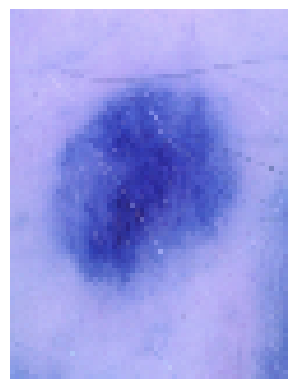

In [10]:
plt.imshow(train_images[5000])
plt.axis("off")
plt.show()

### Model

In [11]:
from tensorflow.keras.layers import Dense,Dropout,Input,Conv2D,MaxPooling2D,Flatten
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.metrics import f1_score

In [12]:
import pandas as pd
excel_file_path = './results/result_history.xlsx'
txt_file_path = "./results/result_history.txt"
data = {
    "version": [],
    "epochs" : [],
    "c1": [],
    "c2": [],
    "c3": [],
    "test_acc": [],
    "train_acc" : [],
    "f1_score" : [],
    "test_loss": [],
    "train_loss": []
}
    

In [13]:
epochs = 150

def build_and_fit_model(model_version,c1,c2,c3):
    model = Sequential()
    model.add(Input(shape=image_input_size))
    model.add(Conv2D(c1,kernel_size=(3,3),activation="relu", kernel_initializer=tf.keras.initializers.Constant(value=0.1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(c2,kernel_size=(3,3),activation="relu", kernel_initializer=tf.keras.initializers.Constant(value=0.1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(c3,kernel_size=(3,3),activation="relu", kernel_initializer=tf.keras.initializers.Constant(value=0.1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(7, kernel_initializer='glorot_uniform',activation="softmax"))
    
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss="categorical_crossentropy",metrics=['accuracy'])
    history = model.fit(x=train_images,y=encoded_train_y,epochs=epochs)
    model.save(f"./results/models/model_{model_version}.h5")
    
    test_loss, test_acc = model.evaluate(test_images, encoded_test_y, verbose=2)
    print('\nTest accuracy:', test_acc , '\nTest loss:', test_loss)
    
    #f1 skoru
    predictions = model.predict(test_images)
    binary_predictions = tf.argmax(predictions, axis=1).numpy()
    true_labels = tf.argmax(encoded_test_y, axis=1).numpy()
    f1 = f1_score(true_labels, binary_predictions, average='weighted')
    print("Ağırlıklandırılmış F1 Sokru:", f1)
    
    ##txt log
    with open(txt_file_path,"a") as file:
        file.write(f"\n{model_version},{int(c1)},{int(c2)},{int(c3)},{test_acc},{test_loss}")
        file.close()
    
    ##dictionery log for excel
    data["version"].append(model_version)
    data["epochs"].append(epochs)
    data["c1"].append(int(c1))
    data["c2"].append(int(c2))
    data["c3"].append(int(c3))
    data["test_acc"].append(test_acc)
    data["test_loss"].append(test_loss)
    data["f1_score"].append(f1)
    data["train_acc"].append(history.history["accuracy"][-1])
    data["train_loss"].append(history.history["loss"][-1])
        
    return test_acc, test_loss

### Parçacık



In [14]:
import random

In [15]:
pso_epochs = 10
class particle:
    def __init__(self,x,v,c1,c2):
        self.x = x
        self.v = v
        self.pbest = self.x
        self.c1 = c1
        self.c2 = c2

    def calculate_speed(self,gbest):
        self.v = self.v  +  self.c1 * random.uniform(0,3) * (self.pbest - self.x)  +  self.c2 *random.uniform(0,3) * (gbest - self.x)
        print(f"{self} par değişim hızı : {self.v}")
        
    def calculate_new_x(self):
        self.x = self.x + self.v
        if(abs(self.x) < abs(self.pbest)):
            self.pbest = self.x
        print(f"{self} par x : {self.x} ")
        print(f"{self} par pbest : {self.pbest}")

    def calculate(self,gbest):
        self.calculate_speed(gbest)
        self.calculate_new_x()

class Particles:
    def __init__(self):
        self.gbest = 1000
        
        self.c1 = 0.7
        self.c2 = 0.2
        
    def define_particles(self,particles_init_p_list):
        particles = []
        for i in range(len(particles_init_p_list)):
            particles.append(particle(particles_init_p_list[i],0,self.c1,self.c2))
        self.particles = particles 
    
    def find_gbest(self):
        for particle in self.particles:
            if(abs(particle.x) < abs(self.gbest)):
                self.gbest = particle.x
    
    def epoch(self,epoch_count):
        self.check_particle_relevance(epoch_count)
        for particle in self.particles:
            print(f"--old par {particle} x : {particle.x} ")
            particle.calculate(self.gbest)
            print(f"--new par {particle} x : {particle.x} \n")
        self.find_gbest()
    
    def check_particle_relevance(self,epoch_count):
        acc,loss = build_and_fit_model(epoch_count,abs(self.particles[0].x),abs(self.particles[1].x),abs(self.particles[2].x))
                    
    def fit(self):
        epoch_counter = 0
        while True:
            if(epoch_counter == pso_epochs):
                self.show_particles_x()
                break
            else:
                print(f"gbest: {self.gbest}")
                #time.sleep(0.1)
                epoch_counter+=1
                print(f"epoch : {epoch_counter}")
                self.epoch(epoch_counter)
                
    def show_particles_x(self):
        i = 0
        for particle in self.particles:
            print(f"index:{i} {particle.x}")
            i+=1
            

### Eğitim

In [16]:
particles = Particles()
particles.define_particles([72,56,64])
particles.find_gbest()
particles.fit()

gbest: 56
epoch : 1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 58, 72)        2016      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 29, 72)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 27, 56)        36344     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 13, 56)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 11, 64)        32320     
                                                                 
 max_pooling2d_2 (MaxPooling  (None,

210/210 [==============================] - 3s 12ms/step - loss: 0.3037 - accuracy: 0.8937
Epoch 143/150
210/210 [==============================] - 3s 12ms/step - loss: 0.3062 - accuracy: 0.8864
Epoch 144/150
210/210 [==============================] - 3s 12ms/step - loss: 0.3091 - accuracy: 0.8869
Epoch 145/150
210/210 [==============================] - 3s 12ms/step - loss: 0.2586 - accuracy: 0.9088
Epoch 146/150
210/210 [==============================] - 3s 12ms/step - loss: 0.2438 - accuracy: 0.9125
Epoch 147/150
210/210 [==============================] - 3s 13ms/step - loss: 0.2218 - accuracy: 0.9204
Epoch 148/150
210/210 [==============================] - 3s 13ms/step - loss: 0.2278 - accuracy: 0.9198
Epoch 149/150
210/210 [==============================] - 3s 13ms/step - loss: 0.2215 - accuracy: 0.9188
Epoch 150/150
210/210 [==============================] - 3s 12ms/step - loss: 0.1866 - accuracy: 0.9298
104/104 - 1s - loss: 1.6406 - accuracy: 0.6841 - 662ms/epoch - 6ms/step

Test 

210/210 [==============================] - 3s 12ms/step - loss: 0.7500 - accuracy: 0.7308
Epoch 121/150
210/210 [==============================] - 2s 12ms/step - loss: 0.7326 - accuracy: 0.7303
Epoch 122/150
210/210 [==============================] - 2s 12ms/step - loss: 0.7301 - accuracy: 0.7306
Epoch 123/150
210/210 [==============================] - 3s 12ms/step - loss: 0.7164 - accuracy: 0.7386
Epoch 124/150
210/210 [==============================] - 3s 12ms/step - loss: 0.7003 - accuracy: 0.7468
Epoch 125/150
210/210 [==============================] - 3s 12ms/step - loss: 0.6881 - accuracy: 0.7531
Epoch 126/150
210/210 [==============================] - 3s 12ms/step - loss: 0.6659 - accuracy: 0.7584
Epoch 127/150
210/210 [==============================] - 3s 13ms/step - loss: 0.6599 - accuracy: 0.7584
Epoch 128/150
210/210 [==============================] - 3s 13ms/step - loss: 0.6620 - accuracy: 0.7572
Epoch 129/150
210/210 [==============================] - 3s 12ms/step - loss: 

210/210 [==============================] - 3s 12ms/step - loss: 0.9525 - accuracy: 0.6827
Epoch 99/150
210/210 [==============================] - 2s 11ms/step - loss: 0.9470 - accuracy: 0.6812
Epoch 100/150
210/210 [==============================] - 2s 11ms/step - loss: 0.9539 - accuracy: 0.6806
Epoch 101/150
210/210 [==============================] - 2s 11ms/step - loss: 0.9454 - accuracy: 0.6832
Epoch 102/150
210/210 [==============================] - 2s 11ms/step - loss: 0.9427 - accuracy: 0.6852
Epoch 103/150
210/210 [==============================] - 2s 11ms/step - loss: 0.9489 - accuracy: 0.6832
Epoch 104/150
210/210 [==============================] - 2s 11ms/step - loss: 0.9333 - accuracy: 0.6857
Epoch 105/150
210/210 [==============================] - 2s 11ms/step - loss: 0.9364 - accuracy: 0.6854
Epoch 106/150
210/210 [==============================] - 3s 12ms/step - loss: 0.9347 - accuracy: 0.6854
Epoch 107/150
210/210 [==============================] - 3s 12ms/step - loss: 0

                                                                 
 dense_3 (Dense)             (None, 7)                 17367     
                                                                 
Total params: 75,333
Trainable params: 75,333
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
210/210 [==============================] - 3s 12ms/step - loss: 360629.5625 - accuracy: 0.4990
Epoch 2/150
210/210 [==============================] - 3s 12ms/step - loss: 19126.8379 - accuracy: 0.5101
Epoch 3/150
210/210 [==============================] - 2s 12ms/step - loss: 5658.1494 - accuracy: 0.5136
Epoch 4/150
210/210 [==============================] - 2s 12ms/step - loss: 2421.4331 - accuracy: 0.5155
Epoch 5/150
210/210 [==============================] - 2s 11ms/step - loss: 957.9266 - accuracy: 0.5292
Epoch 6/150
210/210 [==============================] - 2s 11ms/step - loss: 462.7247 - accuracy: 0.5235
Epoch 7/150
210/210 [==============

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 78, 58, 38)        1064      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 39, 29, 38)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 37, 27, 55)        18865     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 18, 13, 55)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 11, 59)        29264     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 8, 5, 59)        

Epoch 144/150
210/210 [==============================] - 2s 9ms/step - loss: 0.4155 - accuracy: 0.8493
Epoch 145/150
210/210 [==============================] - 2s 9ms/step - loss: 0.3817 - accuracy: 0.8636
Epoch 146/150
210/210 [==============================] - 2s 9ms/step - loss: 0.3873 - accuracy: 0.8624
Epoch 147/150
210/210 [==============================] - 2s 9ms/step - loss: 0.3817 - accuracy: 0.8630
Epoch 148/150
210/210 [==============================] - 2s 9ms/step - loss: 0.3618 - accuracy: 0.8720
Epoch 149/150
210/210 [==============================] - 507s 2s/step - loss: 0.3608 - accuracy: 0.8669
Epoch 150/150
210/210 [==============================] - 2s 9ms/step - loss: 0.3262 - accuracy: 0.8855
104/104 - 1s - loss: 1.3666 - accuracy: 0.6563 - 504ms/epoch - 5ms/step

Test accuracy: 0.6562783718109131 
Test loss: 1.366576910018921
104/104 [==============================] - 0s 3ms/step
Ağırlıklandırılmış F1 Sokru: 0.6488692672636507
--old par <__main__.particle object at

Epoch 43/150
210/210 [==============================] - 1s 7ms/step - loss: 1.0384 - accuracy: 0.6677
Epoch 44/150
210/210 [==============================] - 1s 7ms/step - loss: 1.0344 - accuracy: 0.6657
Epoch 45/150
210/210 [==============================] - 1s 7ms/step - loss: 1.0306 - accuracy: 0.6690
Epoch 46/150
210/210 [==============================] - 2s 7ms/step - loss: 1.0318 - accuracy: 0.6665
Epoch 47/150
210/210 [==============================] - 1s 7ms/step - loss: 1.0311 - accuracy: 0.6675
Epoch 48/150
210/210 [==============================] - 1s 7ms/step - loss: 1.0282 - accuracy: 0.6675
Epoch 49/150
210/210 [==============================] - 2s 7ms/step - loss: 1.0301 - accuracy: 0.6699
Epoch 50/150
210/210 [==============================] - 1s 7ms/step - loss: 1.0212 - accuracy: 0.6720
Epoch 51/150
210/210 [==============================] - 1s 7ms/step - loss: 1.0133 - accuracy: 0.6715
Epoch 52/150
210/210 [==============================] - 1s 7ms/step - loss: 1.0109

210/210 [==============================] - 1s 7ms/step - loss: 0.5672 - accuracy: 0.7931
Epoch 124/150
210/210 [==============================] - 1s 7ms/step - loss: 0.5568 - accuracy: 0.7967
Epoch 125/150
210/210 [==============================] - 1s 7ms/step - loss: 0.5386 - accuracy: 0.8012
Epoch 126/150
210/210 [==============================] - 1s 7ms/step - loss: 0.5304 - accuracy: 0.8010
Epoch 127/150
210/210 [==============================] - 1s 7ms/step - loss: 0.5244 - accuracy: 0.8069
Epoch 128/150
210/210 [==============================] - 1s 7ms/step - loss: 0.4831 - accuracy: 0.8194
Epoch 129/150
210/210 [==============================] - 1s 7ms/step - loss: 0.5053 - accuracy: 0.8133
Epoch 130/150
210/210 [==============================] - 1s 7ms/step - loss: 0.4732 - accuracy: 0.8247
Epoch 131/150
210/210 [==============================] - 1s 7ms/step - loss: 0.4238 - accuracy: 0.8465
Epoch 132/150
210/210 [==============================] - 1s 7ms/step - loss: 0.4177 - a

Epoch 22/150
210/210 [==============================] - 1s 6ms/step - loss: 1.0804 - accuracy: 0.6689
Epoch 23/150
210/210 [==============================] - 1s 6ms/step - loss: 1.0733 - accuracy: 0.6692
Epoch 24/150
210/210 [==============================] - 1s 6ms/step - loss: 1.0696 - accuracy: 0.6694
Epoch 25/150
210/210 [==============================] - 1s 6ms/step - loss: 1.0649 - accuracy: 0.6700
Epoch 26/150
210/210 [==============================] - 1s 6ms/step - loss: 1.0633 - accuracy: 0.6700
Epoch 27/150
210/210 [==============================] - 1s 6ms/step - loss: 1.0600 - accuracy: 0.6696
Epoch 28/150
210/210 [==============================] - 1s 6ms/step - loss: 1.0584 - accuracy: 0.6699
Epoch 29/150
210/210 [==============================] - 1s 6ms/step - loss: 1.0569 - accuracy: 0.6700
Epoch 30/150
210/210 [==============================] - 1s 6ms/step - loss: 1.0584 - accuracy: 0.6696
Epoch 31/150
210/210 [==============================] - 1s 6ms/step - loss: 1.0558

Epoch 1/150
210/210 [==============================] - 1s 4ms/step - loss: 1457.5217 - accuracy: 0.4733
Epoch 2/150
210/210 [==============================] - 1s 3ms/step - loss: 121.7849 - accuracy: 0.4946
Epoch 3/150
210/210 [==============================] - 1s 3ms/step - loss: 33.8025 - accuracy: 0.5010
Epoch 4/150
210/210 [==============================] - 1s 4ms/step - loss: 7.8825 - accuracy: 0.5237
Epoch 5/150
210/210 [==============================] - 1s 4ms/step - loss: 3.2706 - accuracy: 0.5490
Epoch 6/150
210/210 [==============================] - 1s 4ms/step - loss: 2.5403 - accuracy: 0.5624
Epoch 7/150
210/210 [==============================] - 1s 4ms/step - loss: 2.0297 - accuracy: 0.5824
Epoch 8/150
210/210 [==============================] - 1s 4ms/step - loss: 1.6619 - accuracy: 0.6043
Epoch 9/150
210/210 [==============================] - 1s 4ms/step - loss: 1.4250 - accuracy: 0.6304
Epoch 10/150
210/210 [==============================] - 1s 4ms/step - loss: 1.2803 - 

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 78, 58, 9)         252       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 39, 29, 9)        0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 37, 27, 5)         410       
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 18, 13, 5)        0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 11, 18)        828       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 8, 5, 18)         0         
 g2D)     

Epoch 145/150
210/210 [==============================] - 1s 5ms/step - loss: 0.4048 - accuracy: 0.8487
Epoch 146/150
210/210 [==============================] - 1s 6ms/step - loss: 0.4099 - accuracy: 0.8499
Epoch 147/150
210/210 [==============================] - 2s 9ms/step - loss: 0.4186 - accuracy: 0.8441
Epoch 148/150
210/210 [==============================] - 2s 9ms/step - loss: 0.4119 - accuracy: 0.8426
Epoch 149/150
210/210 [==============================] - 2s 7ms/step - loss: 0.3959 - accuracy: 0.8548
Epoch 150/150
210/210 [==============================] - 1s 6ms/step - loss: 0.4002 - accuracy: 0.8468
104/104 - 1s - loss: 1.2251 - accuracy: 0.6593 - 571ms/epoch - 5ms/step

Test accuracy: 0.6593040823936462 
Test loss: 1.2251322269439697
104/104 [==============================] - 0s 2ms/step
Ağırlıklandırılmış F1 Sokru: 0.6518114026167108
--old par <__main__.particle object at 0x000002B178990E20> x : -9.282844477288052 
<__main__.particle object at 0x000002B178990E20> par değiş

Epoch 44/150
210/210 [==============================] - 1s 6ms/step - loss: 1.0506 - accuracy: 0.6712
Epoch 45/150
210/210 [==============================] - 1s 6ms/step - loss: 1.0509 - accuracy: 0.6700
Epoch 46/150
210/210 [==============================] - 1s 6ms/step - loss: 1.0538 - accuracy: 0.6690
Epoch 47/150
210/210 [==============================] - 1s 5ms/step - loss: 1.0516 - accuracy: 0.6703
Epoch 48/150
210/210 [==============================] - 1s 4ms/step - loss: 1.0574 - accuracy: 0.6678
Epoch 49/150
210/210 [==============================] - 1s 5ms/step - loss: 1.0514 - accuracy: 0.6694
Epoch 50/150
210/210 [==============================] - 1s 4ms/step - loss: 1.0539 - accuracy: 0.6669
Epoch 51/150
210/210 [==============================] - 1s 4ms/step - loss: 1.0447 - accuracy: 0.6705
Epoch 52/150
210/210 [==============================] - 1s 5ms/step - loss: 1.0456 - accuracy: 0.6686
Epoch 53/150
210/210 [==============================] - 1s 6ms/step - loss: 1.0482

210/210 [==============================] - 1s 6ms/step - loss: 0.7328 - accuracy: 0.7298
Epoch 125/150
210/210 [==============================] - 1s 5ms/step - loss: 0.7282 - accuracy: 0.7271
Epoch 126/150
210/210 [==============================] - 1s 4ms/step - loss: 0.7145 - accuracy: 0.7337
Epoch 127/150
210/210 [==============================] - 1s 4ms/step - loss: 0.7148 - accuracy: 0.7350
Epoch 128/150
210/210 [==============================] - 1s 4ms/step - loss: 0.7224 - accuracy: 0.7314
Epoch 129/150
210/210 [==============================] - 1s 4ms/step - loss: 0.7110 - accuracy: 0.7359
Epoch 130/150
210/210 [==============================] - 1s 4ms/step - loss: 0.7057 - accuracy: 0.7385
Epoch 131/150
210/210 [==============================] - 1s 6ms/step - loss: 0.7056 - accuracy: 0.7392
Epoch 132/150
210/210 [==============================] - 1s 6ms/step - loss: 0.6926 - accuracy: 0.7441
Epoch 133/150
210/210 [==============================] - 1s 6ms/step - loss: 0.7011 - a

In [17]:
with pd.ExcelWriter(excel_file_path, mode='w') as writer:
    res_df = pd.DataFrame(data)
    res_df.to_excel(writer, index=False, header=False, sheet_name="sheet4")